In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

data = pd.read_csv("E:\DS-portfolio\kaggle-dataset\diabetes.csv")
data.describe()

for col in [col for col in data.columns if col != "Outcome"]:
  data[col] = data[col].astype("float")

data["Outcome"] = data["Outcome"].astype("category")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    float64 
 1   Glucose                   768 non-null    float64 
 2   BloodPressure             768 non-null    float64 
 3   SkinThickness             768 non-null    float64 
 4   Insulin                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    float64 
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(8)
memory usage: 49.0 KB


(array([ 11.,   0.,  15., 156., 268., 224.,  78.,  12.,   3.,   1.]),
 array([ 0.  ,  6.71, 13.42, 20.13, 26.84, 33.55, 40.26, 46.97, 53.68,
        60.39, 67.1 ]),
 <BarContainer object of 10 artists>)

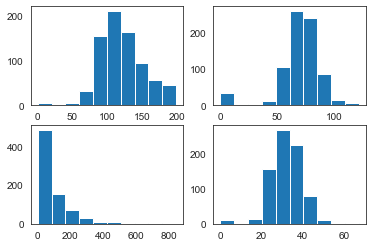

In [3]:
fig, axes = plt.subplots(nrows= 2, ncols= 2)

axes[0][0].hist(data["Glucose"])
axes[0][1].hist(data["BloodPressure"])
axes[1][0].hist(data["Insulin"])
axes[1][1].hist(data["BMI"])


In [4]:
data = data.query("Glucose > 0 & BMI > 0 & BloodPressure > 0")
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,72.400552,21.443370,84.494475,32.467127,0.474765,33.350829
std,3.362803,30.750030,12.379870,15.732756,117.016513,6.888941,0.332315,11.765393
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.500000,0.245000,24.000000
50%,3.000000,117.000000,72.000000,24.000000,48.000000,32.400000,0.379000,29.000000
75%,6.000000,142.000000,80.000000,33.000000,130.500000,36.600000,0.627500,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [5]:
data.loc[data["Glucose"] == 0.0, "Glucose"] = np.NAN
data.loc[data["BloodPressure"] == 0.0, "BloodPressure"] = np.NAN
data.loc[data["SkinThickness"] == 0.0, "SkinThickness"] = np.NAN
data.loc[data["Insulin"] == 0.0, "Insulin"] = np.NAN
data.loc[data["BMI"] == 0.0, "BMI"] = np.NAN

In [6]:
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [7]:
def random_imputation(data, feature):

    number_missing = data[feature].isnull().sum()
    observed_values = data.loc[data[feature].notnull(), feature]
    data.loc[data[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return data

In [8]:
for feature in missing_columns:
    data[feature + '_imp'] = data[feature]
    data = random_imputation(data, feature)

In [9]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

In [10]:
for feature in missing_columns:
    deter_data["Det" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = data[parameters], y = data[feature + '_imp'])
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[data[feature].isnull(), "Det" + feature] = model.predict(data[parameters])[data[feature].isnull()]

In [11]:
from sklearn.impute import KNNImputer
imp = KNNImputer(n_neighbors= 10)

for col in missing_columns:
  data[col] = imp.fit_transform(data[col].to_numpy().reshape(-1,1))

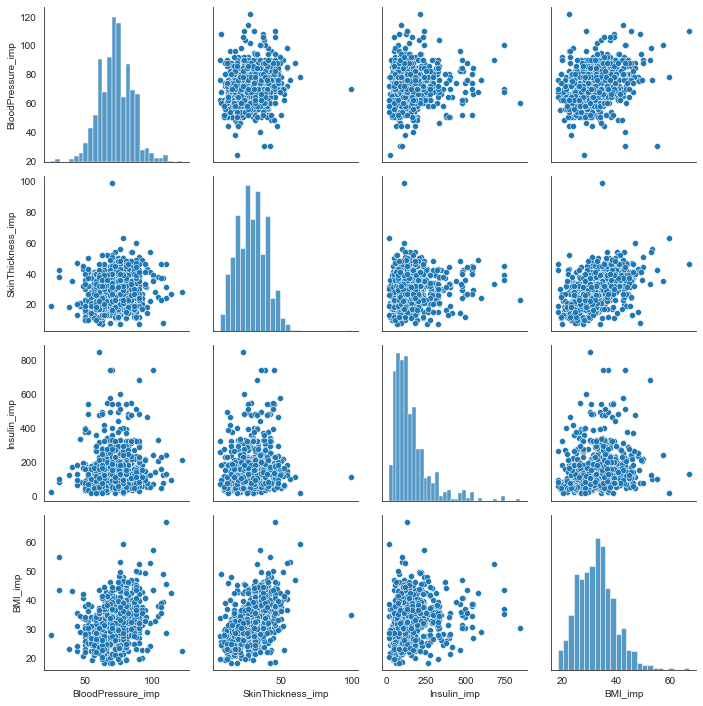

In [12]:
g = sns.PairGrid(data.iloc[:, 10:14])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rfc = RandomForestClassifier(n_estimators= 500, max_depth=5, n_jobs=-1, random_state=99)
X = data.drop(columns= "Outcome")
X = X.iloc[:, [0,6,7,8,9,10,11,12]]
y = data.loc[:, "Outcome"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state= 99)

In [22]:
X.columns

Index(['Pregnancies', 'DiabetesPedigreeFunction', 'Age', 'Glucose_imp',
       'BloodPressure_imp', 'SkinThickness_imp', 'Insulin_imp', 'BMI_imp'],
      dtype='object')

In [27]:
model = rfc.fit(train_X, train_y)
pred_y = rfc.predict(test_X)

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score


print(accuracy_score(test_y, pred_y))
print(roc_auc_score(test_y, pred_y))
print(precision_score(test_y, pred_y))

0.8206896551724138
0.7646683673469388
0.8285714285714286


In [ ]:
import imblearn